# Getting 48h weather forecast and past 7d weather from NWS via webscraping

This script is intended to collect data from the National Weather Service (NWS) into a **_pandas_** dataframe and to create a simple overview figure using **_matplotlib_**. I am later planning to run this script periodically to create an updated figure. 

Data sources: 
1. [NWS Metar Reports](https://www.wrh.noaa.gov/zoa/getobext.php?sid=KCHO)
2. [NWS Hourly Forecast](https://forecast.weather.gov/MapClick.php?lat=38.1386&lon=-78.4528&lg=english&&FcstType=digital)

In [84]:
import requests
import sys
import pandas as pd
import re 
from matplotlib import pyplot as plt 
from matplotlib import gridspec
import matplotlib.dates as mdates
from bs4 import BeautifulSoup

%matplotlib notebook


Select Station using NWS Site Code 

In [78]:
SiteID = "KCHO"
ReportSite = 'https://www.wrh.noaa.gov/zoa/getobext.php?sid=' + SiteID +'&num=168'


In [3]:
TimeNow = pd.to_datetime('today')
YearNow = TimeNow.year


# Define functions to scape data

In [79]:
# Define function to scrape met report 
def ScrapeMetReport(Page):
    "Scrape MetReport Data from NWS for Site with ID and return df(data), str(time of observation), and (coordinates)"
    soup = BeautifulSoup(Page.content, 'html.parser')
    # Extract data from table body
    table_body = soup.find('table',class_="inner-timeseries")
    rows = table_body.find_all('tr')
    tabs=[]
    HeaderLines = 3
    ColumnNames1 = ['Time', 'Temperature', 'Dewpoint', 'Relative Humidity', 'Wind Dir', 'Surface Wind', 'Visibility', 'WX', 'Clouds', 'SLP', 'Altimeter',
               'StationP', '6h TMAX', '6h TMIN', '24h TMAX', '24h TMIN','QC']
    ColumnNames2 = ['Time', 'Temperature', 'Dewpoint', 'Relative Humidity', 'Wind Dir', 'Surface Wind', 'Visibility', 'WX', 'Clouds', 'SLP', 'Altimeter',
               'StationP', 'Rain','P3h','P6h','P24h','6h TMAX', '6h TMIN', '24h TMAX', '24h TMIN','QC']

    for row in rows[HeaderLines:]:
        cols=row.find_all('td')
        cols=[x.text.strip() for x in cols]
        tabs.append(cols)
    # and write data to dataframe
    if (len(cols)==17):
        df = pd.DataFrame(tabs, columns=ColumnNames1) 
    elif (len(cols) == 21):
        df = pd.DataFrame(tabs, columns=ColumnNames2) 
    else:
        raise Exception('Unexpected number of data columns MetReport')
    
    # Convert from string to numeric
    df['Temperature']=pd.to_numeric(df['Temperature'], errors='ignore')
    df['Dewpoint']=pd.to_numeric(df['Dewpoint'], errors='ignore')
    df['6h TMAX']=pd.to_numeric(df['6h TMAX'], errors='ignore')
    df['6h TMIN']=pd.to_numeric(df['6h TMIN'], errors='ignore')    
    df['24h TMAX']=pd.to_numeric(df['24h TMAX'], errors='ignore')
    df['24h TMIN']=pd.to_numeric(df['24h TMIN'], errors='ignore')    
    
    if 'Rain' in df.columns:
        df['Rain']=pd.to_numeric(df['Rain'], errors='ignore')
        df['P3h']=pd.to_numeric(df['P3h'], errors='ignore')
        df['P6h']=pd.to_numeric(df['P6h'], errors='ignore')
        df['P24h']=pd.to_numeric(df['P24h'], errors='ignore')
    
    
    # Adjust to proper date
    YDiff = YearNow-1900
    df['Time'] = pd.to_datetime(df['Time'], format='%d %b %I:%M %p')
    df['Time'] = df['Time'].apply(lambda x: x + pd.DateOffset(years=YDiff))
    df=df.set_index('Time')

    
    # Extract time of observations from website
    table_body = soup.find_all('table')
    rows = table_body[1].find_all('tr')
    cols=rows[2].find_all('td')
    cols=rows[3].find_all('td')
    TimeObs = cols[1].get_text()
    TimeObs = pd.to_datetime(TimeObs.split(',')[1], format=' %d %b %I:%M %p')
    TimeObs = TimeObs + pd.DateOffset(years=YDiff)
    
    # Extract Coordinates 
    LatLonStr = table_body[1].find_all(text=re.compile("Latitude"))
    LatLonStr = re.split(' |;',LatLonStr[0] )
    Coord = tuple([w for w in LatLonStr if re.search('-?[0-9]{1,3}(?:\.[0-9]{1,10})', w)])

    

    
    return df, TimeObs, Coord 
    

In [73]:
# Define function to scrape met forecast
def ScrapeForecast(Page):
    "Scrape 2-day forecast from NWS for Site and return df(data)"
    soup = BeautifulSoup(ForecastPage.content, 'html.parser')
    # The site is a bit of a mess, structure wise. Simply get all table rows on site 
    rows = soup.find_all('tr')
    tabs = []
    for row in rows:
        cols=row.find_all('td')
        cols=[x.text.strip() for x in cols]
        tabs.append(cols)
    
    # Select data by length of columns and get column names
    ColNames = [item[0].split('(')[0].strip() for item in tabs if len(item)==25]
    Data = [item[1:] for item in tabs if len(item)==25]

    # Parse data into dataframe 
    df1 = pd.DataFrame(Data[:int(len(Data)/2)]).transpose()
    df1.columns = ColNames[:int(len(Data)/2)]
    df2 = pd.DataFrame(Data[int(len(Data)/2):]).transpose()
    df2.columns = ColNames[int(len(Data)/2):]        
    df = pd.concat([df1, df2])

    # assemble date 
    df['Year']  = YearNow
    df['Month'], df['Day'] = df['Date'].str.split('/', 1).str
    df['Month']=pd.to_numeric(df['Month'])
    df['Month']=df['Month'].fillna(method='ffill')
    df['Day']=df['Day'].fillna(method='ffill')
    df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=df['Day'], hour=df['Hour']))
    df = df.rename(columns={'Date': 'Time'})
    df.drop(['Year','Month','Day','Hour'], axis=1, inplace=True)

    # set time as index turb columns to numeric
    df=df.set_index('Time')

    df['Temperature']=pd.to_numeric(df['Temperature'], errors='ignore')
    df['Dewpoint']=pd.to_numeric(df['Dewpoint'], errors='ignore')

    return df

# Main body: Execute the code and return dataframes

In [80]:
try:
    # Open page and parse to soup
    ReportPage = requests.get(ReportSite)
    RepDf, TimeObs, SiteCoord =ScrapeMetReport(ReportPage)
except:
    print('Failed to read MetReport - Something went wrong')
    sys.exit()


#RepDf

In [32]:
# Assemble webpage of forcast for site location
ForecastSite = 'https://forecast.weather.gov/MapClick.php?lat={:6.4f}&lon={:6.4f}&lg=english&&FcstType=digital'.format(float(SiteCoord[0]),float(SiteCoord[1]))
#ForecastSite

In [74]:
try:
    # Open page and parse to soup
    ForecastPage = requests.get(ForecastSite)
    ForecastDf =ScrapeForecast(ForecastPage)
except:
    print('Failed to read Forecast - Something went wrong')
    sys.exit()
    
#ForecastDf 

DatetimeIndex(['2018-06-14 16:00:00', '2018-06-14 17:00:00',
               '2018-06-14 18:00:00', '2018-06-14 19:00:00',
               '2018-06-14 20:00:00', '2018-06-14 21:00:00',
               '2018-06-14 22:00:00', '2018-06-14 23:00:00',
               '2018-06-15 00:00:00', '2018-06-15 01:00:00',
               '2018-06-15 02:00:00', '2018-06-15 03:00:00',
               '2018-06-15 04:00:00', '2018-06-15 05:00:00',
               '2018-06-15 06:00:00', '2018-06-15 07:00:00',
               '2018-06-15 08:00:00', '2018-06-15 09:00:00',
               '2018-06-15 10:00:00', '2018-06-15 11:00:00',
               '2018-06-15 12:00:00', '2018-06-15 13:00:00',
               '2018-06-15 14:00:00', '2018-06-15 15:00:00',
               '2018-06-15 16:00:00', '2018-06-15 17:00:00',
               '2018-06-15 18:00:00', '2018-06-15 19:00:00',
               '2018-06-15 20:00:00', '2018-06-15 21:00:00',
               '2018-06-15 22:00:00', '2018-06-15 23:00:00',
               '2018-06-

# To Do ... Plotting 

<IPython.core.display.Javascript object>


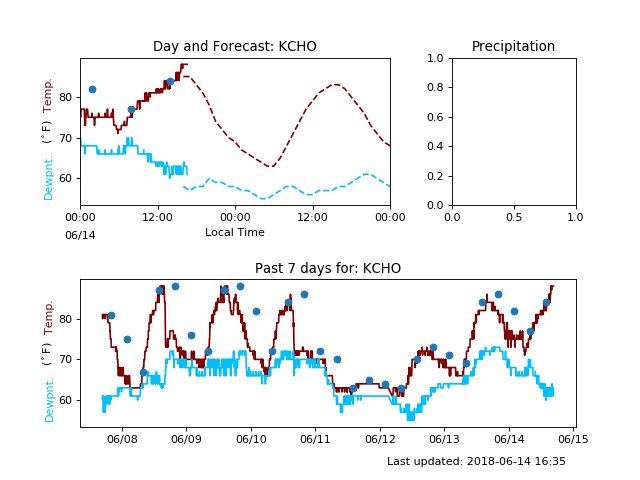

In [122]:
# work in progress 

TMx =RepDf['6h TMAX'].dropna()
TMn = RepDf['6h TMAX'].dropna()

fig = plt.figure(figsize=(8, 6), dpi=80)
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0,:2])
plt.title('Day and Forecast: ' + SiteID) ;
plt.plot(RepDf.index, RepDf.Temperature, color = 'maroon')
plt.plot(RepDf.index, RepDf.Dewpoint, color = 'deepskyblue')
plt.plot(ForecastDf.index, ForecastDf.Temperature, color = 'maroon',linestyle = '--')
plt.plot(ForecastDf.index, ForecastDf.Dewpoint, color = 'deepskyblue',linestyle = '--')
plt.xlim(pd.datetime.now().date(), pd.datetime.now().date() + pd.DateOffset(days=2))

# does not work, need to resample timeseries and then find the time or just find the time without resampling first
#plt.plot(TMx,linestyle='none', marker = 'o')

plt.ylabel('($^\circ$F)')

monthyearFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,12)))
ax1.xaxis.set_major_formatter(monthyearFmt)
ax1.text(0.00, -0.17,  TimeObs.strftime('%m/%d'),
        verticalalignment='top',horizontalalignment='center',
        transform=ax1.transAxes,fontsize=10)
ax1.text(-0.1, 0.75,  'Temp.',
        verticalalignment='center',horizontalalignment='center', 
        transform=ax1.transAxes,fontsize=10, color = 'maroon', rotation = 90)
ax1.text(-0.1, 0.2,  'Dewpnt.',
        verticalalignment='center',horizontalalignment='center', 
        transform=ax1.transAxes,fontsize=10, color = 'deepskyblue', rotation = 90)

plt.xlabel('Local Time')

ax2 = fig.add_subplot(gs[0,2])
plt.title('Precipitation')

ax3 = fig.add_subplot(gs[1,:])
plt.title('Past 7 days for: ' + SiteID)

plt.plot(RepDf.index, RepDf.Temperature, color = 'maroon')
plt.plot(RepDf.index, RepDf.Dewpoint, color = 'deepskyblue')

#plt.plot(TMx,linestyle='none', marker = 'o')
plt.ylabel('($^\circ$F)')
ax3.text(0.98, -0.2, 'Last updated: ' + TimeObs.strftime('%Y-%m-%d %H:%M'),
        verticalalignment='top', horizontalalignment='right',
        transform=ax3.transAxes,fontsize=10)
ax3.text(-0.06, 0.75,  'Temp.',
        verticalalignment='center',horizontalalignment='center', 
        transform=ax3.transAxes,fontsize=10, color = 'maroon', rotation = 90)
ax3.text(-0.06, 0.2,  'Dewpnt.',
        verticalalignment='center',horizontalalignment='center', 
        transform=ax3.transAxes,fontsize=10, color = 'deepskyblue', rotation = 90)

monthyearFmt = mdates.DateFormatter('%m/%d')
ax3.xaxis.set_major_formatter(monthyearFmt)

gs.update(wspace=0.5, hspace=0.5)



In [118]:
RepDf['6h TMAX'].dropna()

Time
2018-06-14 13:53:00    84.0
2018-06-14 07:53:00    77.0
2018-06-14 01:53:00    82.0
2018-06-13 19:53:00    86.0
2018-06-13 13:53:00    84.0
2018-06-13 07:53:00    69.0
2018-06-13 01:53:00    71.0
2018-06-12 19:53:00    73.0
2018-06-12 13:53:00    70.0
2018-06-12 07:53:00    63.0
2018-06-12 01:53:00    64.0
2018-06-11 19:53:00    65.0
2018-06-11 13:53:00    63.0
2018-06-11 07:53:00    70.0
2018-06-11 01:53:00    72.0
2018-06-10 19:53:00    86.0
2018-06-10 13:53:00    84.0
2018-06-10 07:53:00    72.0
2018-06-10 01:53:00    82.0
2018-06-09 19:53:00    88.0
2018-06-09 13:53:00    87.0
2018-06-09 07:53:00    72.0
2018-06-09 01:53:00    76.0
2018-06-08 19:53:00    88.0
2018-06-08 13:53:00    87.0
2018-06-08 07:53:00    67.0
2018-06-08 01:53:00    75.0
2018-06-07 19:53:00    81.0
Name: 6h TMAX, dtype: float64